# Download CIFAR-10 Dataset

In [2]:
import torch
import torchvision

In [ ]:
from torchvision import datasets, transforms

# Define a transformation (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize
])

# Download the dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100%|██████████| 170M/170M [00:10<00:00, 17.0MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000


## shape of inputs

In [23]:
x, y = train_dataset[0]
print(f"Image shape: {x.shape}")
print(f"Label: {y}")
data = [x[0] for x in train_dataset]
data = torch.stack(data, dim=0)
print(f"{data.shape = }")

Image shape: torch.Size([3, 32, 32])
Label: 6
data.shape = torch.Size([50000, 3, 32, 32])


In [26]:
# check mean and std
print(f"{data.mean(dim=[0, 2, 3]) = }")
print(f"{data.std(dim=[0, 2, 3]) = }")

data.mean(dim=[0, 2, 3]) = tensor([-1.2871e-06, -1.7074e-04,  1.1819e-04])
data.std(dim=[0, 2, 3]) = tensor([1.0001, 0.9999, 1.0000])


## Visualize data

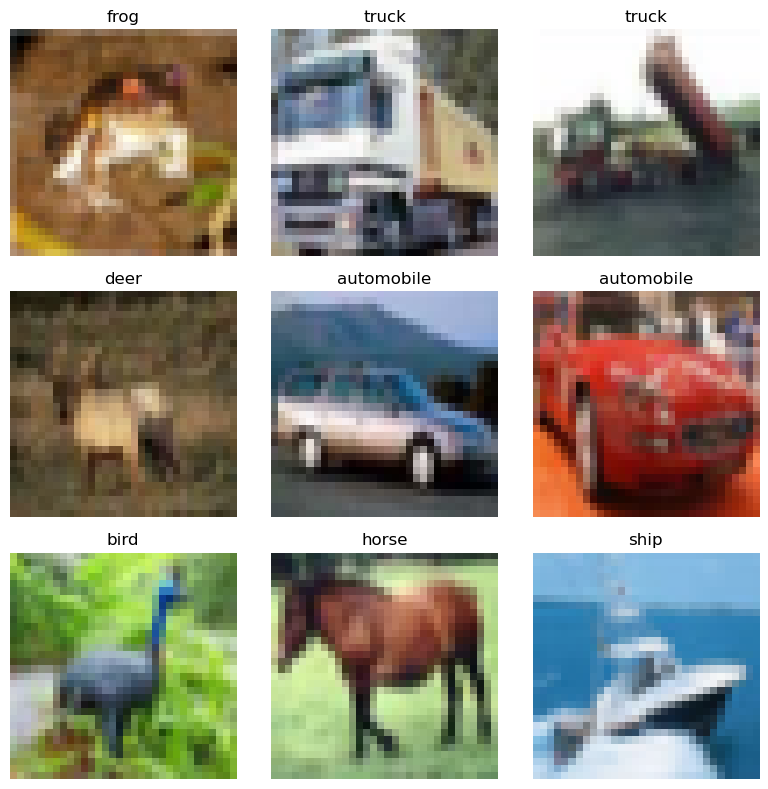

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define CIFAR-10 class names
class_names = train_dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', ...]

# Function to denormalize and convert tensor to numpy image
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to (H, W, C)
    img = img * std + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Clip pixel values to [0,1]
    return img

# Plot some images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = train_dataset[i]  # Get image & label
    # ax.imshow(denormalize(image), interpolation='bilinear')  # or 'nearest'
    ax.imshow(denormalize(image))
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

# Data Augmentations

# Data Pipeline - Data Class and DataLoaders

In [33]:
from torch.utils.data import DataLoader, TensorDataset

# set dataloaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# check dataloader
for x, y in train_loader:
    print(f"{x.shape = }")
    print(f"{y.shape = }")
    break

x.shape = torch.Size([100, 3, 32, 32])
y.shape = torch.Size([100])


# Model - ViT

## Embedding

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=2, in_channels=3, emb_dim=24):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2  # 256 for 2x2 patches on 32x32
        self.linear_projection = nn.Linear(in_channels * patch_size * patch_size, emb_dim)

        # Special classification token
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Learnable position embeddings
        self.positional_emb = nn.Embedding(self.n_patches + 1, emb_dim)

        # Register position IDs so they move with model
        self.register_buffer("position_ids", torch.arange(self.n_patches + 1).unsqueeze(0))

    def forward(self, x):  # x: (B, 3, 32, 32)
        B, C, H, W = x.shape  # (Batch, Channels, Height, Width)
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, 16, 16, 3, 2, 2)
        x = x.view(B, self.n_patches, -1)  # (B, 256, 12)
        x = self.linear_projection(x)  # (B, 256, emb_dim)

        # Prepend the CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Expand to (B, 1, emb_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 257, emb_dim)

        # Add position embeddings (expanded across batch)
        pos_emb = self.positional_emb(self.position_ids).expand(B, -1, -1)  # (B, 257, emb_dim)
        x += pos_emb
        return x
    

# test
B = 8
emb = PatchEmbedding()
x = torch.randn(B, 3, 32, 32)
y = emb(x)
y.shape

torch.Size([8, 257, 24])

## Transformer Encoder 

In [80]:
import torch
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_ratio * emb_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * emb_dim, emb_dim),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):  # x: (B, N, emb_dim)
        # Multi-Head Self-Attention
        attn_output, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))  # (B, N, emb_dim)
        x = x + self.dropout1(attn_output)  # Residual connection

        # Feedforward Network (MLP)
        mlp_output = self.mlp(self.norm2(x))  # (B, N, emb_dim)
        x = x + self.dropout2(mlp_output)  # Residual connection

        return x  # (B, N, emb_dim)
    
class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim, num_heads, num_layers, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x):  # x: (B, N, d_hidden)
        for layer in self.layers:
            x = layer(x)
        return x  # (B, N, d_hidden)

In [81]:
# test
B = 8
N = 257
emb_dim = 24
num_heads = 3

# Dummy Input: Batch of 8 images, 257 tokens (CLS + 256 patches), 24 embedding dim
x = torch.randn(B, N, emb_dim)

# Define a 6-layer Transformer Encoder (like ViT-Tiny)
transformer = TransformerEncoder(
    emb_dim=emb_dim,  # d_hidden (matches patch embedding)
    num_heads=num_heads,  # Multi-head attention heads
    num_layers=6,  # Number of transformer blocks
    mlp_ratio=4,  # Standard ViT MLP expansion
    dropout=0.1
)

out = transformer(x)  # Output shape: (8, 257, 24)
print(out.shape)  # Should be (8, 257, 24)

emb = PatchEmbedding(emb_dim=emb_dim)
x = torch.randn(B, 3, 32, 32)
x = emb(x) 
out = transformer(x)
out.shape

# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# in one transformer block
p = count_parameters(TransformerEncoderBlock(emb_dim=emb_dim, num_heads=num_heads))
print(f"TransformerEncoderBlock parameters: {p}")

# in transformer encoder
p = count_parameters(TransformerEncoder(emb_dim=emb_dim, num_heads=num_heads, num_layers=6))
print(f"TransformerEncoder parameters: {p}")


torch.Size([8, 257, 24])
TransformerEncoderBlock parameters: 7224
TransformerEncoder parameters: 43344


## Classification Head

In [78]:
import torch.nn as nn

class ClassificationHead(nn.Module):
    def __init__(self, emb_dim, num_classes, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Dropout(dropout),  # Added dropout for regularization
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):  # x: (B, N, emb_dim)
        x_cls = x[:, 0, :]  # Extract CLS token (B, emb_dim)
        return self.mlp(x_cls)  # Output shape: (B, num_classes)

In [79]:
# test
B = 8
N = 257
emb_dim = 24
num_classes = 10

# Dummy Input: Batch of 8 images, 257 tokens (CLS + 256 patches), 24 embedding dim
x = torch.randn(B, N, emb_dim)

# Define a classification head
head = ClassificationHead(emb_dim=emb_dim, num_classes=num_classes)

out = head(x)  # Output shape: (8, 10)
print(out.shape)  # Should be (8, 10)

torch.Size([8, 10])


## Full Model

In [87]:
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, config): 
        super().__init__()

        # Store config for easy debugging
        self.config = config  

        # Initialize components
        self.patch_embed = PatchEmbedding(
            config["img_size"], config["patch_size"], config["in_channels"], config["emb_dim"]
        )
        self.transformer = TransformerEncoder(
            config["emb_dim"], config["num_heads"], config["num_layers"], config["mlp_ratio"], config["dropout"]
        )
        self.class_head = ClassificationHead(config["emb_dim"], config["num_classes"], config["dropout"])

        # Print Model Summary
        print(f"ViT Model: {config['num_layers']} layers, {config['num_heads']} heads, emb_dim={config['emb_dim']}")

    def forward(self, x):
        x = self.patch_embed(x)
        #print(f"After Patch Embedding: {x.shape}")  # Debugging line

        x = self.transformer(x)
        #print(f"After Transformer Encoder: {x.shape}")  # Debugging line

        out = self.class_head(x)
        #print(f"Final Output Shape: {out.shape}")  # Debugging line
        return out

In [88]:
# get config from cifar_config.yaml
import yaml

with open("cifar_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# test
B = config["training"]["batch_size"]
C = config["model"]["in_channels"]
H = config["model"]["img_size"]
x = torch.randn(B, C, H, H)

# model
vit = ViT(config["model"])
out = vit(x)
print(out.shape)

ViT Model: 6 layers, 3 heads, emb_dim=24
torch.Size([64, 10])


# Lightning Module

In [89]:
import pytorch_lightning as pl
import torchmetrics

class VIT(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.vit = ViT(config["model"])
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Accuracy metric
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=config["model"]["num_classes"])

    def forward(self, x):
        return self.vit(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Log training loss
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)  # Compute accuracy
        
        # Log test loss & accuracy
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)

        return {"test_loss": loss, "test_acc": acc}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.config["training"]["learning_rate"], 
            weight_decay=self.config["training"]["weight_decay"]
        )
        return optimizer

In [90]:
# test
B = config["training"]["batch_size"]
C = config["model"]["in_channels"]
H = config["model"]["img_size"]
x = torch.randn(B, C, H, H)

model = VIT(config)
out = model(x)
print(out.shape)

ViT Model: 6 layers, 3 heads, emb_dim=24
torch.Size([64, 10])


# Trainer Setup

In [ ]:
with open("cifar_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = VIT(config).to(device)

#trainer = pl.Trainer(max_epochs=config["training"]["epochs"])
trainer = pl.Trainer(
    max_epochs=1,  
    accelerator="mps" if torch.backends.mps.is_available() else "cpu",
    limit_train_batches=0.1,  
    limit_val_batches=0.1
)

trainer.fit(model, train_loader, test_loader)  # Using test_dataloader for validation
trainer.test(model, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | vit      | ViT                | 50.1 K | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | test_acc | MulticlassAccuracy | 0      | train
--------------------------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.201     Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Using device: mps
ViT Model: 6 layers, 3 heads, emb_dim=24
Epoch 0: 100%|██████████| 50/50 [00:08<00:00,  6.05it/s, v_num=1, train_loss=2.140]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing DataLoader 0: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2363000065088272
        test_loss           2.0856518745422363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.0856518745422363, 'test_acc': 0.2363000065088272}]

# Metrics and Evaluations

# Training

In [93]:
# get config
with open("cifar_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = VIT(config).to(device)

trainer = pl.Trainer(max_epochs=config["training"]["epochs"], accelerator=config["hardware"]["device"])

trainer.fit(model, train_loader, test_loader)  # Using test_dataloader for validation
trainer.test(model, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/itamarshamir/miniconda3/envs/my_vision/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | vit      | ViT                | 50.1 K | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | test_acc | MulticlassAccuracy | 0      | train
--------------------------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.201     Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode
/Users/itamarshamir/miniconda3/envs/my_vision/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' 

Using device: mps
ViT Model: 6 layers, 3 heads, emb_dim=24
Epoch 9: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s, v_num=2, train_loss=1.330]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s, v_num=2, train_loss=1.330]


/Users/itamarshamir/miniconda3/envs/my_vision/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5586000084877014
        test_loss            1.206242561340332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.206242561340332, 'test_acc': 0.5586000084877014}]